## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw

### System dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations

Position is sensed, perturbed by Gaussian noise:

$$y_k = C z_k + r_k$$

where $r_k$ is measurement noise with covariance matrix $R$. 

## Experiments

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `/home/synd/Wouter/Onderzoek/Projecten/tue/efe-acquisition/marxefe-mp`


In [2]:
using Revise
using Colors
using Optim
using DomainSets
using JLD2
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using StatsPlots
using Plots; default(label="", grid=false, markersize=3, margin=15Plots.pt)
using RxInfer; RxInfer.disable_inference_error_hint!()
includet("envs/Robots.jl"); using. Robots
includet("../src/util.jl");

┌ Info: Inference error hints are disabled. Restart Julia session for the change to take effect.
└ @ RxInfer /home/wmkouw/.julia/packages/RxInfer/jqOCS/src/inference/inference.jl:228


In [3]:
includet("../distributions/matrix_normal_wishart.jl");
includet("../distributions/mv_location_scale_t.jl");
includet("../distributions/unboltzmann.jl");
includet("../nodes/MARX.jl");
includet("../nodes/matrix_normal_wishart.jl");
includet("../rules/MARX/in.jl");
includet("../rules/MARX/out.jl");
includet("../rules/MARX/parameter.jl");
includet("../rules/matrix_normal_wishart/out.jl")

In [75]:
# Trial number (saving id)
trialnum = 01

# Time
Δt = 0.1
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 1;

# Dimensionalities
Mu = 2
My = 2
Dy = 2
Du = Dy
Dx = My*Dy + (Mu+1)*Du
Dz = 4

# Parameters
σ = 1e-4*ones(Dy)
ρ = 1e-3*ones(Dy)

# Limits of controller
global u_lims = (-3.0, 3.0)
opts = Optim.Options(time_limit=0.1)

# Initial state
z_0 = [-5., -5., 0., 0.]

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Prior parameters
ν0 = 20
Ω0 = 1e0*diagm(ones(Dy))
Λ0 = 1e-3*diagm(ones(Dx))
M0 = 1e-8*randn(Dx,Dy)
Υ  = 1e-6*diagm(ones(Dy));

In [76]:
@model function MARX_learning(y_k,y_kmin1,y_kmin2,u_k,u_kmin1,u_kmin2, M_kmin1,Λ_kmin1,Ω_kmin1,ν_kmin1)
    "Update MARX parameters"

    # Prior distribution over MARX parameters
    Φ ~ MatrixNormalWishart(M_kmin1, Λ_kmin1, Ω_kmin1, ν_kmin1)

    # MARX Likelihood
    y_k ~ MARX(y_kmin1,y_kmin2,u_k,u_kmin1,u_kmin2,Φ)

end

In [77]:
function posterior_predictive(x_t,M,Λ,Ω,ν,Dx,Dy)
    "Posterior predictive distribution is multivariate T-distributed."

    η_t = ν - Dy + 1
    μ_t = M'*x_t
    Σ_t = 1/(ν-Dy+1)*Ω*(1 + x_t'*inv(Λ)*x_t)

    return η_t, μ_t, Σ_t
end

posterior_predictive (generic function with 1 method)

### Learning

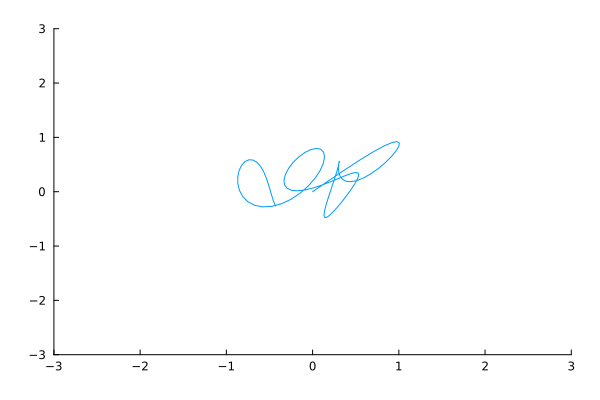

In [78]:
# Generate actions
u_A = rand(10,2)*30
u_ϕ = rand(10,2)*3
u_sim = [mean([u_A[i,1]*sin.(u_ϕ[i,1].*tsteps) for i = 1:10])' ./ 10;
         mean([u_A[i,2]*sin.(u_ϕ[i,2].*tsteps) for i = 1:10])' ./ 10]
plot(u_sim[1,:], u_sim[2,:], xlims=u_lims, ylims=u_lims)

In [79]:
# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
# F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

ybuffer = zeros(Dy,My)
ubuffer = zeros(Du,Mu+1)

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Goal prior parameters
m_star = [-5., 5.]
S_star = 1e-3diagm(ones(Dy))
goal = MvNormal(m_star, S_star)

# Fix starting state
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])
ybuffer = backshift(ybuffer,y_sim[:,1])
ubuffer = backshift(ubuffer,u_sim[:,1])
Ms[:,:,1] = M0
Λs[:,:,1] = Λ0
Ωs[:,:,1] = Ω0
νs[1] = ν0

for k in 2:len_trial

    """Make predictions"""

    x_k = [ybuffer[:]; ubuffer[:]]
    η,μ,Σ = posterior_predictive(x_k,Ms[:,:,k-1],Λs[:,:,k-1],Ωs[:,:,k-1],νs[k-1],Dx,Dy)
    preds_m[:,k] = μ
    preds_S[:,:,k] = Σ*η/(η-2)

    """Update beliefs"""

    # Update system with action
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k])

    # Update input buffer
    ubuffer = backshift(ubuffer,u_sim[:,k])

    # Update MARX parameter belief
    results = infer(
        model = MARX_learning(y_kmin1 = ybuffer[:,1],
                              y_kmin2 = ybuffer[:,2],
                              u_k     = ubuffer[:,1],
                              u_kmin1 = ubuffer[:,2],
                              u_kmin2 = ubuffer[:,3],
                              M_kmin1 = Ms[:,:,k-1],
                              Λ_kmin1 = Λs[:,:,k-1],
                              Ω_kmin1 = Ωs[:,:,k-1],
                              ν_kmin1 = νs[k-1]),
        data = (y_k = y_sim[:,k],),
    )

    # Track belief
    Ms[:,:,k],Λs[:,:,k],Ωs[:,:,k],νs[k] = params(results.posteriors[:Φ])

    # Update output buffer
    ybuffer = backshift(ybuffer,y_sim[:,k])

end

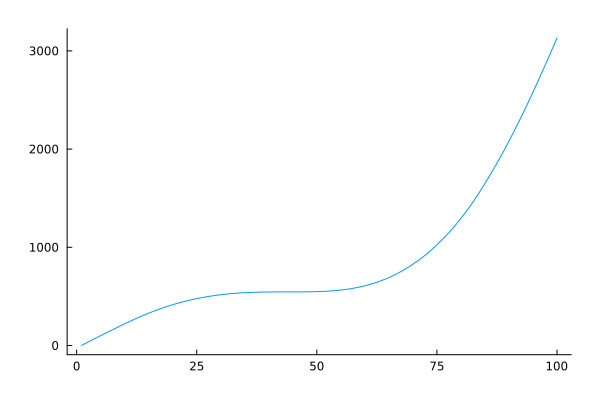

In [80]:
plot(Λs[1,1,:])

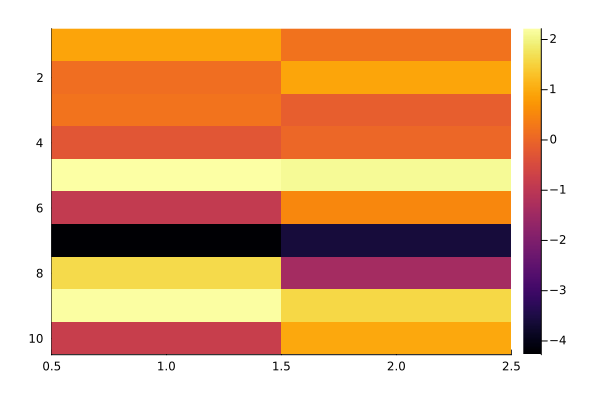

In [81]:
heatmap(Ms[:,:,end], yflip=true)

In [11]:
# twin = 10:len_trial
# plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy", xscale=:log10)

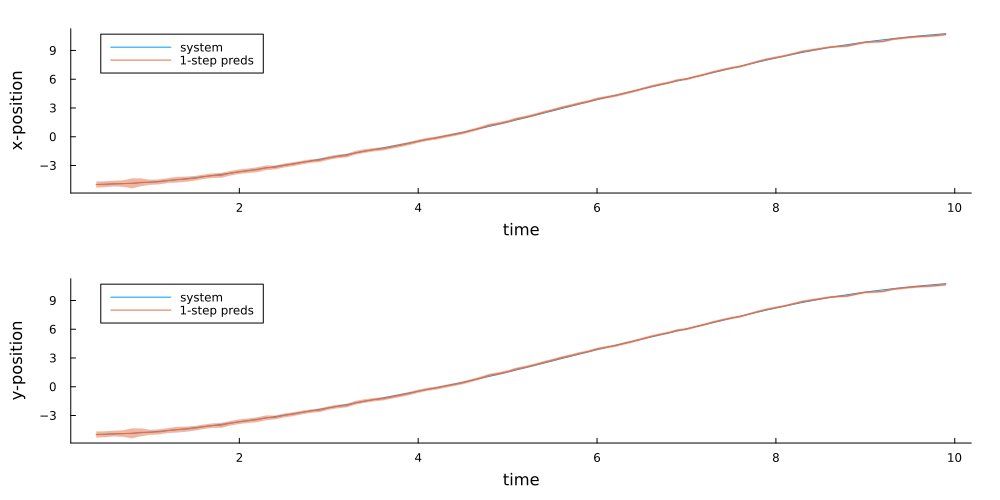

In [82]:
twin = 5:len_trial

p101 = plot(xlabel="time", ylabel="x-position")
plot!(tsteps[twin],z_sim[1,twin], label="system")
plot!(tsteps[twin],preds_m[1,twin], ribbon=sqrt.(preds_S[1,1,twin]), label="1-step preds")

p102 = plot(xlabel="time", ylabel="y-position")
plot!(tsteps[twin],z_sim[1,twin], label="system")
plot!(tsteps[twin],preds_m[1,twin], ribbon=sqrt.(preds_S[2,2,twin]), label="1-step preds")

plot(p101,p102, layout=(2,1), size=(1000,500))

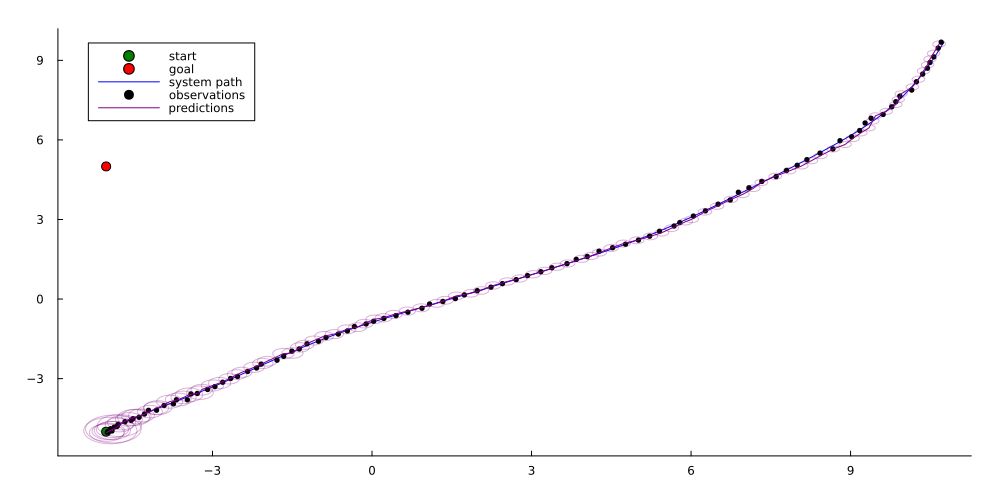

In [83]:
twin = 4:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")

plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, fillalpha=0.001, linecolor="purple", color="purple")
end
plot!(size=(1000,500))
# plot!(aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1))

### Planning

#### 1-step ahead

In [84]:
@model function MARX_planning(y_tmin1,y_tmin2,u_tmin1,u_tmin2, M_k,Λ_k,Ω_k,ν_k,Υ,m_star,S_star,)
    "1-step ahead planning"

    # Action prior
    u_t ~ MvNormalMeanPrecision(zeros(Du),Υ)

    # Posterior distribution over MARX parameters
    Φ   ~ MatrixNormalWishart(M_k,Λ_k,Ω_k,ν_k)

    # MARX likelihood for future time-step
    y_t ~ MARX(y_tmin1,y_tmin2,u_t,u_tmin1,u_tmin2,Φ)

    # Goal prior
    y_t ~ MvNormalMeanCovariance(m_star,S_star)

end

In [85]:
# Time
Δt = 0.1
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 1;

# Goal prior parameters
m_star = [1., 1.]
S_star = 0.5diagm(ones(Dy))
goal = MvNormal(m_star, S_star)

# Prior parameters
ν0 = 100
Ω0 = 1e0*diagm(ones(Dy))
Λ0 = 1e-2*diagm(ones(Dx))
M0 = ones(Dx,Dy) / (Dy*Dx)
Υ  = 1e-12*diagm(ones(Dy));

# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
u_sim   = zeros(Du,len_trial)
# F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

ybuffer = zeros(Dy,My)
ubuffer = zeros(Du,Mu+1)

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Fix starting state
z_0        = [-1., -1., 0., 0.]
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])
ybuffer    = backshift(ybuffer,y_sim[:,1])
ubuffer    = backshift(ubuffer,u_sim[:,1])
Ms[:,:,1]  = M0
Λs[:,:,1]  = Λ0
Ωs[:,:,1]  = Ω0
νs[1]      = ν0

plans = []

@showprogress for k in 2:len_trial

    """Make predictions"""

    x_k = [ybuffer[:]; ubuffer[:]]
    η,μ,Σ = posterior_predictive(x_k,Ms[:,:,k-1],Λs[:,:,k-1],Ωs[:,:,k-1],νs[k-1],Dx,Dy)
    preds_m[:,k] = μ
    preds_S[:,:,k] = Σ*η/(η-2)

    """Update beliefs"""

    # Update system with action
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])

    # Update input buffer
    ubuffer = backshift(ubuffer,u_sim[:,k-1])

    # Update MARX parameter belief
    results_learning = infer(
        model = MARX_learning(y_kmin1 = ybuffer[:,1],
                              y_kmin2 = ybuffer[:,2],
                              u_k     = ubuffer[:,1],
                              u_kmin1 = ubuffer[:,2],
                              u_kmin2 = ubuffer[:,3],
                              M_kmin1 = Ms[:,:,k-1],
                              Λ_kmin1 = Λs[:,:,k-1],
                              Ω_kmin1 = Ωs[:,:,k-1],
                              ν_kmin1 = νs[k-1]),
        data = (y_k = y_sim[:,k],),
    )

    # Track belief
    Ms[:,:,k],Λs[:,:,k],Ωs[:,:,k],νs[k] = params(results_learning.posteriors[:Φ])

    # Update output buffer
    ybuffer = backshift(ybuffer,y_sim[:,k])

    """Plan actions"""

    inits = @initialization begin
        q(Φ)   = results_learning.posteriors[:Φ]
        q(y_t) = vague(MvNormalMeanCovariance,Dy)
        q(u_t) = vague(MvNormalMeanCovariance,Du)
        μ(y_t) = vague(MvNormalMeanCovariance,Dy)
        μ(u_t) = vague(MvNormalMeanCovariance,Du)
        μ(Φ)   = results_learning.posteriors[:Φ]
    end

    constraints = @constraints begin
        q(y_t,u_t,Φ) = q(y_t)q(u_t)q(Φ)
    end


    # Feed updated beliefs, goal prior params and buffers to planning model
    results_planning = infer(
        model = MARX_planning(M_k    = Ms[:,:,k],
                              Λ_k    = Λs[:,:,k],
                              Ω_k    = Ωs[:,:,k],
                              ν_k    = νs[k],
                              Υ      = Υ,
                              m_star = m_star, 
                              S_star = S_star,),
        data = (y_tmin1 = ybuffer[:,1],
                y_tmin2 = ybuffer[:,2],
                u_tmin1 = ubuffer[:,1],
                u_tmin2 = ubuffer[:,2],),
        initialization = inits,
        constraints = constraints,
        iterations = 1, 
        options = (limit_stack_depth=100,),
    )
    push!(plans, results_planning)

    # Extract action
    # u_sim[:,k] = mode(results_planning.posteriors[:u_t][end], u_lims=u_lims)
    u_sim[:,k] = clamp!(mode(results_planning.posteriors[:u_t][end]), u_lims...)

end

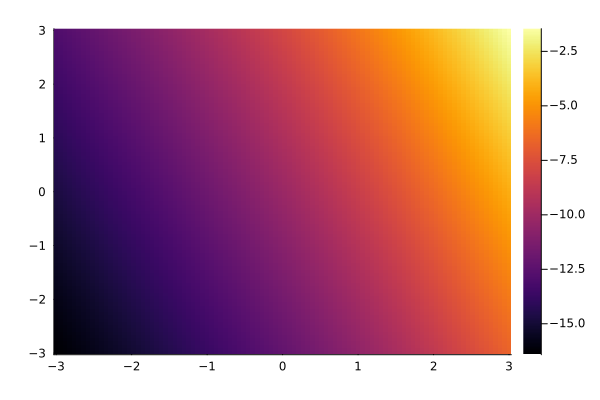

In [86]:
# Inspect q(u_t)

timepoint = 50
num_cells = 100
uu = range(u_lims[1], stop=u_lims[2], length=num_cells)

landscape = zeros(num_cells,num_cells)
for (ii,ui) in enumerate(uu)
    for (jj,uj) in enumerate(uu)
        landscape[ii,jj] = plans[timepoint].posteriors[:u_t][end].G([ui,uj])
    end
end
heatmap(uu,uu,landscape)

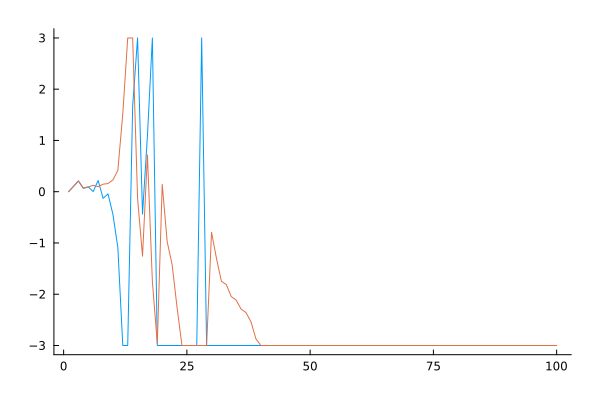

In [87]:
plot(u_sim')

In [18]:
# jldsave("results/MARXEFE-botnav-trialnum$trialnum.jld2"; z_sim, u_sim, y_sim, Ms, Λs, Ωs, νs, Υ)

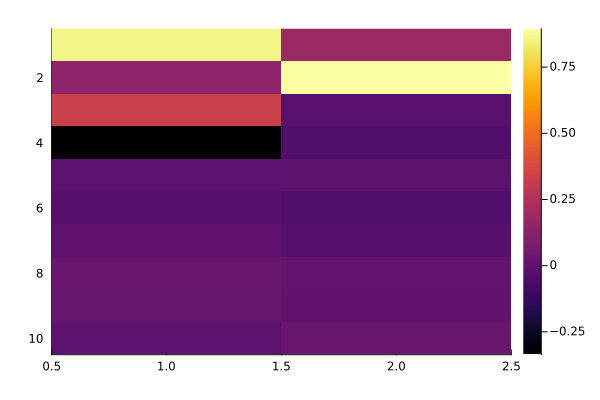

In [88]:
heatmap(Ms[:,:,end], yflip=true)

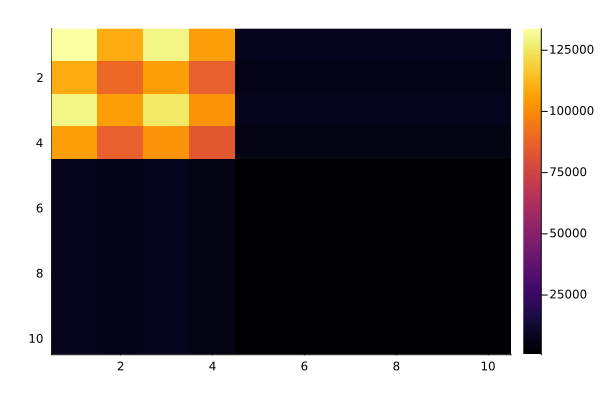

In [89]:
heatmap(Λs[:,:,end], yflip=true)

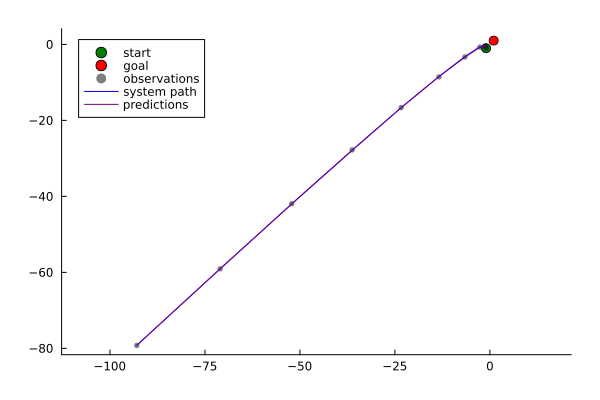

In [90]:
# twin = len_trial-1000:2:len_trial
twin = 10:10:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!(y_sim[1,twin], y_sim[2,twin], alpha=0.5, label="observations", color="black")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")

for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, alpha=0.001, fillalpha=0.0001, color="purple")
end
plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
plot!(aspect_ratio=:equal)
# plot!(xlims=(-3,3), ylims=(-3,3))

#### K-step ahead

In [91]:
@model function MARX_planning(y_tmin1,y_tmin2,u_tmin1,u_tmin2, M_k,Λ_k,Ω_k,ν_k,Υ,m_star,S_star,)
    "1-step ahead planning"

    # Posterior distribution over MARX parameters
    Φ   ~ MatrixNormalWishart(M_k,Λ_k,Ω_k,ν_k)

    "t = 1"

    # Action prior
    u_1 ~ MvNormalMeanPrecision(zeros(Du),Υ)

    # MARX likelihood for future time-step
    y_1 ~ MARX(y_tmin1,y_tmin2,u_1,u_tmin1,u_tmin2,Φ)

    "t = 2"

    # Action prior
    u_2 ~ MvNormalMeanPrecision(zeros(Du),Υ)

    # MARX likelihood for future time-step
    y_2 ~ MARX(y_1,y_tmin1,u_2,u_1,u_tmin1,Φ)

    "t = 3"

    # Action prior
    u_3 ~ MvNormalMeanPrecision(zeros(Du),Υ)

    # MARX likelihood for future time-step
    y_3 ~ MARX(y_2,y_1,u_3,u_2,u_1,Φ)

    # Goal prior
    y_3 ~ MvNormalMeanCovariance(m_star,S_star)
    
end

In [ ]:
# Time
Δt = 0.2
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 3;

# Goal prior parameters
m_star = [1., 1.]
S_star = 0.5diagm(ones(Dy))
goal = MvNormal(m_star, S_star)

# Prior parameters
ν0 = 100
Ω0 = 1e0*diagm(ones(Dy))
Λ0 = 1e-2*diagm(ones(Dx))
M0 = ones(Dx,Dy) / (Dy*Dx)
Υ  = 1e-12*diagm(ones(Dy));

# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
u_sim   = zeros(Du,len_trial)
# F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

ybuffer = zeros(Dy,My)
ubuffer = zeros(Du,Mu+1)

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Fix starting state
z_0        = [-1., -1., 0., 0.]
z_sim[:,1] = z_0
u_sim[:,1] = clamp!(randn(2), u_lims...)
y_sim[:,1] = emit(fbot, z_sim[:,1])
ybuffer    = backshift(ybuffer,y_sim[:,1])
ubuffer    = backshift(ubuffer,u_sim[:,1])
Ms[:,:,1]  = M0
Λs[:,:,1]  = Λ0
Ωs[:,:,1]  = Ω0
νs[1]      = ν0

beliefs = []
plans = []

@showprogress for k in 2:len_trial

    """Make predictions"""

    x_k = [ybuffer[:]; ubuffer[:]]
    η,μ,Σ = posterior_predictive(x_k,Ms[:,:,k-1],Λs[:,:,k-1],Ωs[:,:,k-1],νs[k-1],Dx,Dy)
    preds_m[:,k] = μ
    preds_S[:,:,k] = Σ*η/(η-2)

    """Update beliefs"""

    # Update system with action
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])

    # Update input buffer
    ubuffer = backshift(ubuffer,u_sim[:,k-1])

    # Update MARX parameter belief
    results_learning = infer(
        model = MARX_learning(y_kmin1 = ybuffer[:,1],
                              y_kmin2 = ybuffer[:,2],
                              u_k     = ubuffer[:,1],
                              u_kmin1 = ubuffer[:,2],
                              u_kmin2 = ubuffer[:,3],
                              M_kmin1 = Ms[:,:,k-1],
                              Λ_kmin1 = Λs[:,:,k-1],
                              Ω_kmin1 = Ωs[:,:,k-1],
                              ν_kmin1 = νs[k-1]),
        data = (y_k = y_sim[:,k],),
    )
    push!(beliefs,results_learning)

    # Track belief
    Ms[:,:,k],Λs[:,:,k],Ωs[:,:,k],νs[k] = params(results_learning.posteriors[:Φ])

    # Update output buffer
    ybuffer = backshift(ybuffer,y_sim[:,k])

    """Plan actions"""

    inits = @initialization begin
        q(Φ)   = results_learning.posteriors[:Φ]
        q(y_1) = vague(MvNormalMeanCovariance,Dy)
        q(y_2) = vague(MvNormalMeanCovariance,Dy)
        q(y_3) = vague(MvNormalMeanCovariance,Dy)
        q(u_1) = vague(MvNormalMeanCovariance,Du)
        q(u_2) = vague(MvNormalMeanCovariance,Du)
        q(u_3) = vague(MvNormalMeanCovariance,Du)
        μ(y_1) = vague(MvNormalMeanCovariance,Dy)
        μ(y_2) = vague(MvNormalMeanCovariance,Dy)
        μ(y_3) = vague(MvNormalMeanCovariance,Dy)
        μ(u_1) = vague(MvNormalMeanCovariance,Du)
        μ(u_2) = vague(MvNormalMeanCovariance,Du)
        μ(u_3) = vague(MvNormalMeanCovariance,Du)
        μ(Φ)   = results_learning.posteriors[:Φ]
    end

    constraints = @constraints begin
        q(y_1,y_2,y_3,u_1,u_2,u_3,Φ) = q(y_1)q(y_2)q(y_3)q(u_1)q(u_2)q(u_3)q(Φ)
    end

    # Feed updated beliefs, goal prior params and buffers to planning model
    results_planning = infer(
        model = MARX_planning(M_k    = Ms[:,:,k],
                              Λ_k    = Λs[:,:,k],
                              Ω_k    = Ωs[:,:,k],
                              ν_k    = νs[k],
                              Υ      = Υ,
                              m_star = m_star, 
                              S_star = S_star,),
        data = (y_tmin1 = ybuffer[:,1],
                y_tmin2 = ybuffer[:,2],
                u_tmin1 = ubuffer[:,1],
                u_tmin2 = ubuffer[:,2],),
        initialization = inits,
        constraints = constraints,
        iterations = 3, 
        options = (limit_stack_depth=100,),
    )
    push!(plans, results_planning)

    # Extract action
    # u_sim[:,k] = mode(results_planning.posteriors[:u_1][end], u_lims=u_lims)
    u_sim[:,k] = clamp!(mode(results_planning.posteriors[:u_1][end]), u_lims...)

end

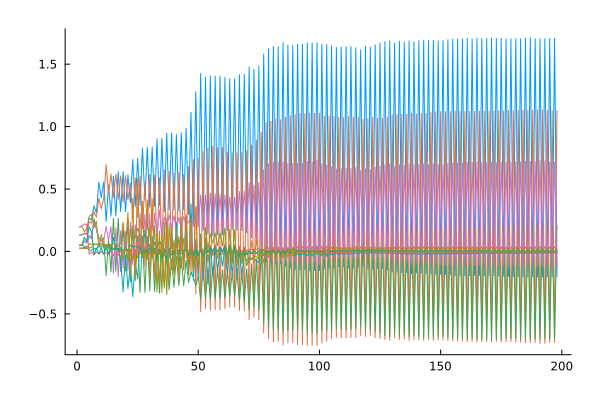

In [99]:
plot(cat([mean(beliefs[i].posteriors[:Φ]) for i in 1:len_trial-1]..., dims=2)')

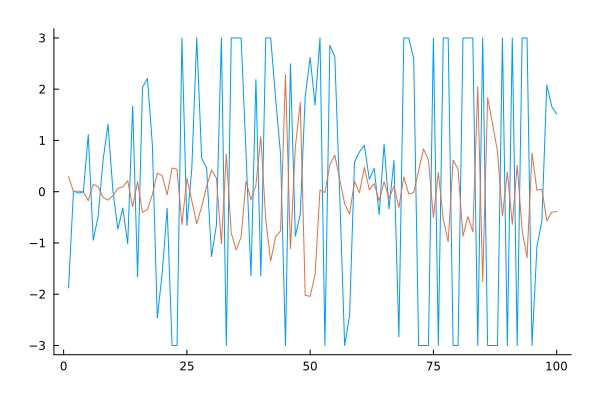

In [100]:
plot(u_sim')

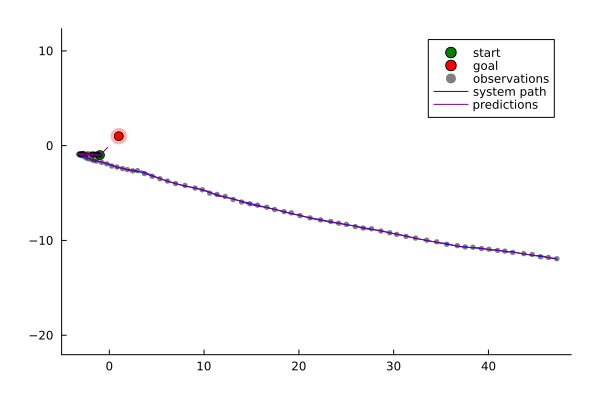

In [101]:
# twin = len_trial-1000:2:len_trial
twin = 2:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!(y_sim[1,twin], y_sim[2,twin], alpha=0.5, label="observations", color="black")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")

for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, alpha=0.001, fillalpha=0.0001, color="purple")
end
plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
plot!(aspect_ratio=:equal)
# plot!(xlims=(-3,3), ylims=(-3,3))

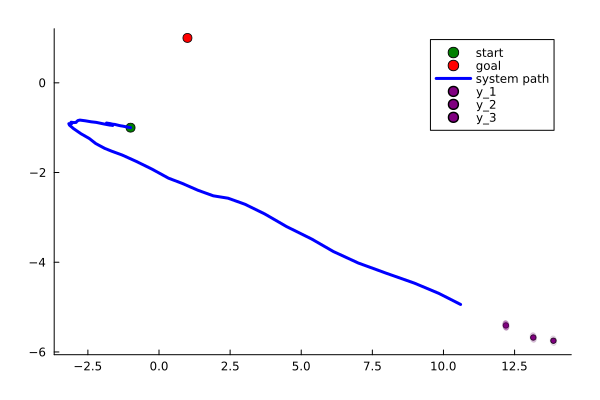

In [116]:
tpoint = 60

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)

scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
# covellipse!(mean(goal), cov(goal), n_std=1., linewidth=1, fillalpha=0.1, linecolor="red", color="red")

# scatter!(y_sim[1,tpoint], y_sim[2,tpoint], alpha=0.5, label="observations", color="black")
plot!(z_sim[1,1:tpoint], z_sim[2,1:tpoint], linewidth=3, label="system path", color="blue")

for tt in 1:3
    preds = [plans[k].posteriors[Symbol("y_$tt")][end] for k in 1:len_trial-1]
    scatter!([mean(preds[tpoint])[1]], [mean(preds[tpoint])[2]], label="y_$tt", color="purple")
    covellipse!(mean(preds[tpoint]), cov(preds[tpoint]), n_std=1, alpha=0.1, fillalpha=0.5^tt, color="purple")
end
plot!()

In [28]:
plot(cat(mean.(plans[10].posteriors[:y_1])..., dims=2)')

BoundsError: BoundsError: attempt to access 0-element Vector{Any} at index [10]